# Imports

Import the wheel containing the parser class (and some other stuff).

In [6]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

from sklearn.preprocessing import power_transform
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from utils.fetcher import Fetcher as f
from utils.museum import Museum
from enricher import Enricher as e

# Fetch the Dataframe Using the Parser Class
The parser will fetch a collection of Wikipedia data and dump it into a Dataframe for easier use by a Data Scientist. Once this step is completed there no further use for the parser.

The ```fetch_museum_data method``` will take a ```minimum_visitors``` argument that filters the list of museums returned (to those with a visitors value meeting or exceeding the parameter value).  Use this to scope the query.

NOTE: This is a relatively slow process - since the parser is crawling the Wikipedia page's museum and city links.  

In [8]:
from museum_data_compiler import MuseumParser

parser = MuseumParser()
museum_df = parser.fetch_museum_data()

fetchhing museum list ...
enriching record for Louvre ...
fetchhing city poplulation data for Louvre ...
fetchhing museum details for Louvre ...
enriching record for Vatican Museums ...
fetchhing city poplulation data for Vatican Museums ...
fetchhing museum details for Vatican Museums ...
enriching record for Natural History Museum ...
fetchhing city poplulation data for Natural History Museum ...
fetchhing museum details for Natural History Museum ...
enriching record for British Museum ...
fetchhing museum details for British Museum ...
enriching record for National Museum of Natural History ...
fetchhing city poplulation data for National Museum of Natural History ...
fetchhing museum details for National Museum of Natural History ...
enriching record for Tate Modern ...
fetchhing museum details for Tate Modern ...
enriching record for National Museum of Korea ...
fetchhing city poplulation data for National Museum of Korea ...
fetchhing museum details for National Museum of Korea 

# Or ... Fetch the Dataframe From a CSV Compiled Previously
The 'run_job' script in the Parser container runs the code in the cell above and dumps the CVS to a file on disk.  To speed things up a bit we can just relaod a previoulsy parsed set of Wikipedia data.

In [7]:
filename = '../data/museum_data_1702001985889696.csv'
museum_df = pd.read_csv(filename, sep='\t')

In [9]:
museum_df.head()

,name,city,country,visitors,city_population,urban_population,longitude,latitude,museum_type
0,Louvre,Paris,France,7726321,2102650,10858852.0,NaN,NaN,Art museum and historic site
1,Vatican Museums,Vatican City,Vatican City,5080866,764,NaN,41.90639,12.45444,Art museum
2,Natural History Museum,London,United Kingdom,4654608,8799800,9787426.0,51.49611,-0.17639,Natural history museum
3,British Museum,London,United Kingdom,4097253,8799800,9787426.0,NaN,NaN,None
4,National Museum of Natural History,"Washington, D.C.",United States,3900000,689545,5174759.0,38.89130,-77.02590,Natural History


In [6]:
museum_df.describe()

,Unnamed: 0,visitors,city_population,urban_population,longitude,latitude
count,27.000000,2.700000e+01,2.700000e+01,2.000000e+01,17.000000,17.000000
mean,13.000000,3.159999e+06,6.311284e+06,1.022411e+07,40.707869,20.627169
std,7.937254,1.218204e+06,5.360234e+06,5.517521e+06,11.440816,74.236548
min,0.000000,2.025800e+06,7.640000e+02,1.390051e+06,22.300958,-77.025900
25%,6.500000,2.317465e+06,2.102650e+06,5.951940e+06,37.523890,-0.176390
50%,13.000000,2.812913e+06,5.601911e+06,9.787426e+06,40.779400,2.326390
75%,19.500000,3.385540e+06,8.799800e+06,1.085885e+07,51.496110,113.326336
max,26.000000,7.726321e+06,2.189310e+07,2.189310e+07,59.938742,126.980280


This is a really small dataset - dealing with variance will be a problem.

In [8]:
# Filter data set to desired subset
museum_df = museum_df[museum_df.visitors >= 2000000]

### Check our 'primary' independent.

<Axes: >

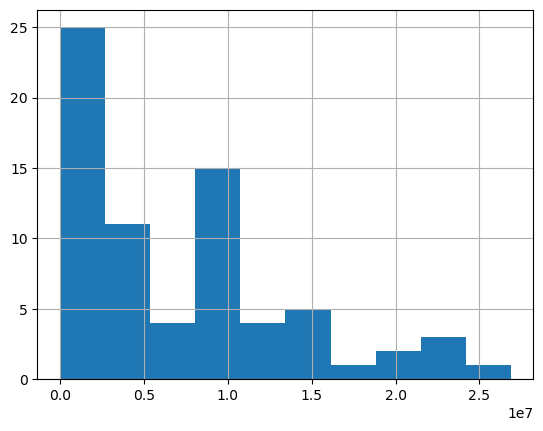

In [10]:
museum_df['city_population'].hist(bins=10)

Terrible. Let's try a quick log transformation:

<Axes: >

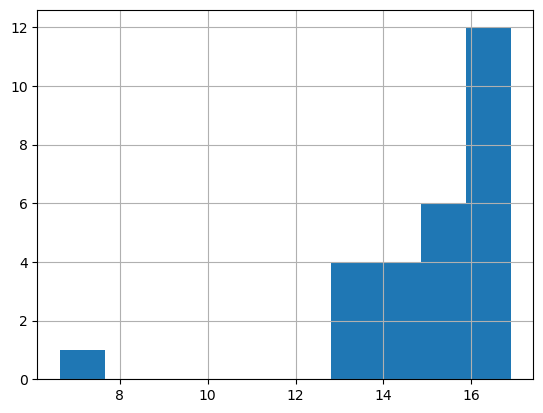

In [10]:
museum_df['log_city_population'] = np.log(museum_df['city_population'])
museum_df['log_city_population'].hist(bins=10)

Still terrible.

### Vatican City and Normalization
Vatican City is causing us some problems.  Manually address this by updating the city population value to that of Rome. 2,860,009 according to Wikipedia

Then let's see what some alternate normalization techniques look like.

array([[<Axes: title={'center': 'city_population'}>,
        <Axes: title={'center': 'log_city_population'}>],
       [<Axes: title={'center': 'yj_city_population'}>,
        <Axes: title={'center': 'bc_city_population'}>]], dtype=object)

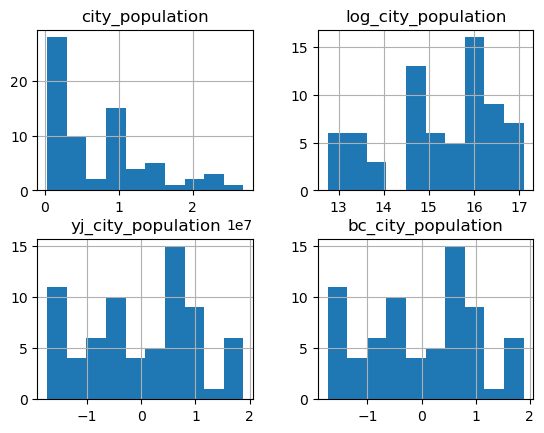

In [11]:
museum_df.loc[museum_df['name']=='Vatican Museums', 'city_population'] = 2860009
museum_df['log_city_population'] = np.log(museum_df['city_population'])
museum_df['yj_city_population'] = power_transform(np.array(museum_df['city_population']).reshape(-1, 1), method='yeo-johnson', standardize=True)
museum_df['bc_city_population'] = power_transform(np.array(museum_df['city_population']).reshape(-1, 1), method='box-cox', standardize=True)

museum_df.hist(column=['city_population', 'log_city_population', 'yj_city_population', 'bc_city_population'], bins=10)

Some marginally better options, but still not looking promising.  Box-Sox and Yeo-Johnson seem roughly equivalent, but improved over a the log transform.  We'll check Box-Cox from here:

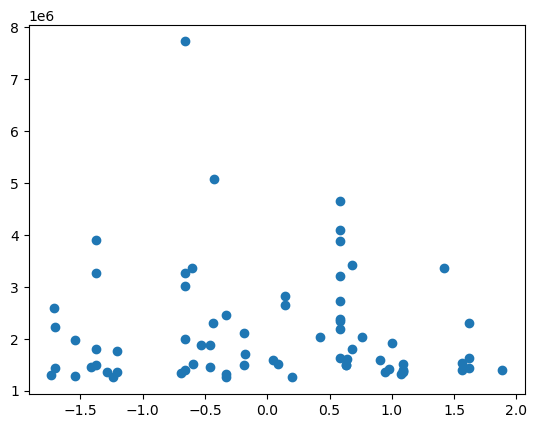

In [12]:
plt.scatter(museum_df['bc_city_population'], museum_df['visitors'])

This does not look hopeful.  Even ignoring the outlier(s), it's hard to see how a linear regression would differ much from the the mean.  A multivariate regression, might be able to find something, and/or maybe there are some additional feartures that can be engineered.

### Add a 'museums in city' feature

There is no point in running this on on museum dataframe filtered to >= 2,000,000 anual visitors - there is simply too little data and does not reflect what this sort of feature would be trying to capture (i.e. a network effect)

array([[<Axes: title={'center': 'museums_in_city'}>,
        <Axes: title={'center': 'log_museums_in_city'}>],
       [<Axes: title={'center': 'yj_museums_in_city'}>,
        <Axes: title={'center': 'bc_museums_in_city'}>]], dtype=object)

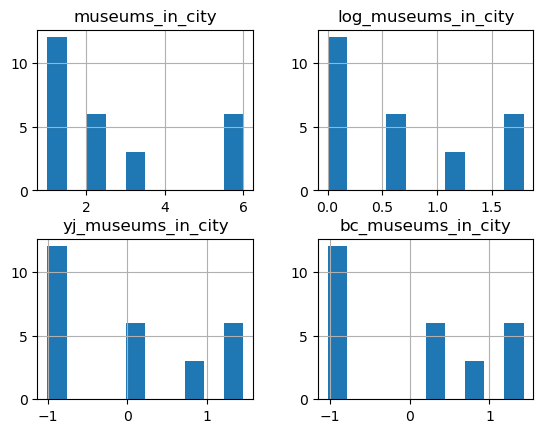

In [13]:
museum_df['museums_in_city'] = museum_df['name'].groupby(museum_df['city']).transform('count')

museum_df['log_museums_in_city'] = np.log(museum_df['museums_in_city'])
museum_df['yj_museums_in_city'] = power_transform(np.array(museum_df['museums_in_city']).reshape(-1, 1), method='yeo-johnson', standardize=True)
museum_df['bc_museums_in_city'] = power_transform(np.array(museum_df['museums_in_city']).reshape(-1, 1), method='box-cox', standardize=True)

museum_df.hist(column=['museums_in_city', 'log_museums_in_city', 'yj_museums_in_city', 'bc_museums_in_city'])

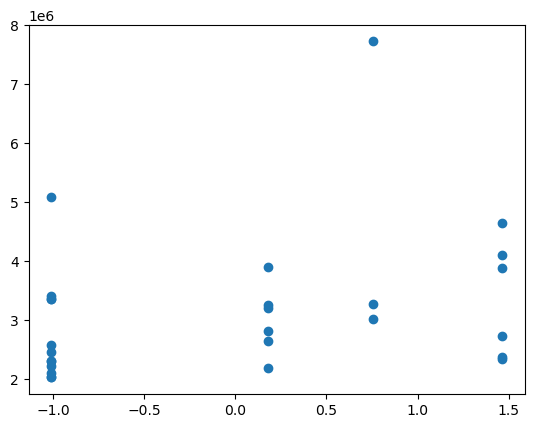

In [14]:
plt.scatter(museum_df['yj_museums_in_city'], museum_df['visitors'])

So that does not look like a particularly useful feature either.  Again, maybe this is useful in a context outside of simple linear regression.

# Setup a basic (univariate) Linear Regression

Oversample the entire set to address our variance problem.

Based on some early testing the filtered dataset is too small to get anything resembling a meaningful correlation on this data.  Oversampling seems like a reasonable step to get a sense of what kind of performance we can get on the 'population' feature. 

In [22]:
# oversample_df = museum_df[~museum_df.name.isin(['Louvre']) & ~museum_df.country.isin(['China'])]
oversample_df = museum_df.sample(n=1500, replace=True, random_state=13)

In [23]:
X = np.array(oversample_df['log_city_population']).reshape(-1, 1)
y = np.array(oversample_df['visitors']).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [24]:
model = LinearRegression()
model.fit(X_train, y_train)

model.score(X_test, y_test)

-0.00031662802494980546

Extremely poor result.

In [27]:
print(model.intercept_, model.coef_, model.score(X, y))

[2736645.37185585] [[-41499.17360483]] 0.002002132049202965


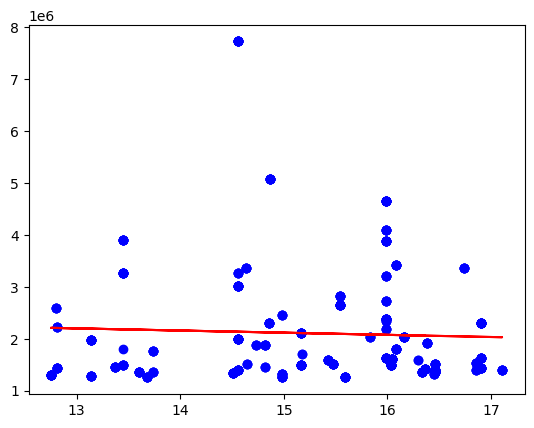

In [28]:
y_pred = model.predict(X_test)

plt.scatter(X_test, y_test, color ='b')

plt.plot(X_test, y_pred, color ='r')

plt.show()

# Multivariate Regression
We can attempt to improve the model by adding in the Country variable.  We could add the city variable, but the fact that there is frequently a 1:1 relationship between a museum and a city means that we'd probably end up with a grossly overfit model that simply maps city names to museum names, with some additional error. 

NOTE: The first step drops the 'museums_in_city' features.  If you didn't run the cells to create them, they should be commented out.

In [30]:
pd.get_dummies(museum_df, columns = ['country'])
# Clean the dataframe up a bit to focus on country as a second independent.
copy_df = oversample_df.drop(columns=[
    'name', 
    'city', 
    'country', 
    'city_population', 
    'urban_population', 
    'longitude', 
    'latitude', 
    'museum_type', 
    'log_city_population', 
    'bc_city_population', 
    # 'museums_in_city', 
    # 'log_museums_in_city',
    # 'yj_museums_in_city', 
    # 'bc_museums_in_city'
])

In [31]:
X = copy_df.drop('visitors',axis= 1) 
y = copy_df['visitors'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [32]:
model = LinearRegression()
model.fit(X_train, y_train)

model.score(X_test, y_test)

0.008731331264028253

In [33]:
print(model.intercept_, model.coef_, model.score(X, y))

2126927.71957393 [-70667.99080949] 0.00567842212980163


Still terrible.  The nominal imrpovement in the R2 is probably due to increasing the number of independents in regression, and has nothing to do with any predictive power.